In [11]:
using PyPlot

In [12]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = zeros(N*K,D) # data matrix (each row = single example)
y = zeros(Int64, N*K) # class labels
for j in range(1,K)
    idx = range(1+N*(j-1), N); #index for X and Y
    r = linspace(0.0,1,N); # radius
    t = linspace((j-1)*4,(j)*4,N) + randn(N)*0.2 # theta
    X[idx,:] = [r.*sin(t) r.*cos(t)]
    y[idx] = j;
end

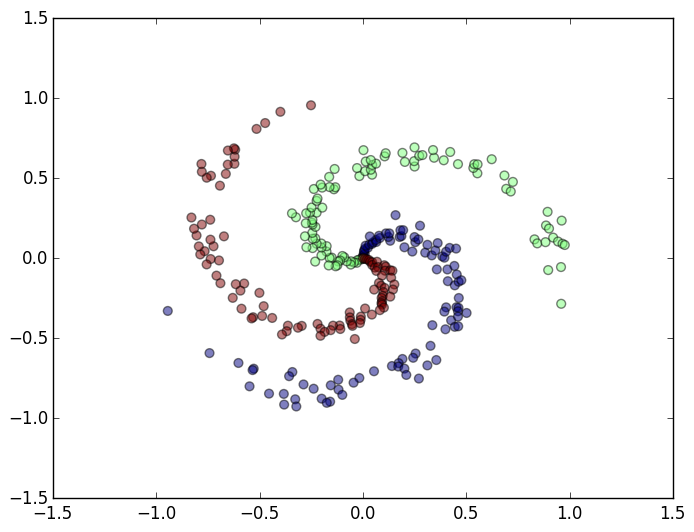

PyObject <matplotlib.collections.PathCollection object at 0x000000002AF20F60>

In [13]:
# lets visualize the data:
scatter(X[:, 1], X[:, 2], s=40, c=y, alpha=0.5)

In [14]:
# initialize parameters randomly
h = 100 # size of hidden layer
W1 = 0.01 * randn(D,h)
b1 = zeros(1,h)
W2 = 0.01 * randn(h,K)
b2 = zeros(1,K)

1x3 Array{Float64,2}:
 0.0  0.0  0.0

In [15]:
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength


0.001

we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since $r = max(0, x)$, we have that $\frac{dr}{dx} = 1(x > 0)$. Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than 0, but kills it if its input was less than zero during the forward pass.

The derivative of hard ReLU is constant over two ranges x<0 and x>=0, for x>0, g’=1, and x<0, g’=0.

In [ ]:
function relu(x)
    return max(0,x);
end

In [18]:
# gradient descent loop
num_examples = size(X,1)
numIterations = 10000
J = zeros(numIterations,1);
for i in 1:numIterations
    # evaluate class scores, [N x K]
    hidden_layer = relu(X*W1 .+ b1) # note, ReLU activation
    scores = hidden_layer*W2 .+ b2
    
    # compute the class probabilities (softmax)
    exp_scores = exp(scores);
    probs = exp_scores ./ sum(exp_scores, 2) # [N x K]
    
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = zeros(num_examples)
    for j in 1:num_examples
        corect_logprobs[j] = -log(probs[j,y[j]]);
    end
    data_loss = sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*sum(W1.^2) + 0.5*reg*sum(W2.^2)
    J[i,:] = data_loss + reg_loss
    if i==1 || i % 1000 == 0
        println("iteration: ", i," loss: ", J[i,:])
    end
    
    # compute the gradient on scores
    dscores = probs;
    for j in 1:size(dscores,1)
        dscores[j,y[j]] -= 1;
    end
    dscores /= num_examples;
    
    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = hidden_layer'*dscores
    db2 = sum(dscores, 1)
    # next backprop into hidden layer
    dhidden = dscores*W2'
    
    #println(size(hidden_layer))
    #println(size(dhidden))
    # backprop the ReLU non-linearity
    dhidden[hidden_layer .<= 0] = 0
    
    # finally into W,b
    dW1 = X'*dhidden
    db1 = sum(dhidden, 1)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW1 += reg * W1

    # perform a parameter update
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2 
end

iteration: 1 loss: [1.0985757294179497]
iteration: 1000 loss: [0.3159644620393642]
iteration: 2000 loss: [0.2726204100098884]
iteration: 3000 loss: [0.257132289228387]
iteration: 4000 loss: [0.2578857418678003]
iteration: 5000 loss: [0.25139540015571965]
iteration: 6000 loss: [0.25137054576364015]
iteration: 7000 loss: [0.2532335348990071]
iteration: 8000 loss: [0.249559582415466]
iteration: 9000 loss: [0.24899504581894222]
iteration: 10000 loss: [0.2509519410754443]


Kinks in the objective. One source of inaccuracy to be aware of during gradient checking is the problem of kinks. Kinks refer to non-differentiable parts of an objective function, introduced by functions such as ReLU ($max(0,x)$), or the SVM loss, Maxout neurons, etc. Consider gradient checking the ReLU function at $x=−1e6$. Since $x<0$, the analytic gradient at this point is exactly zero. However, the numerical gradient would suddenly compute a non-zero gradient because $f(x+h)$ might cross over the kink (e.g. if $h>1e−6$) and introduce a non-zero contribution. You might think that this is a pathological case, but in fact this case can be very common. For example, an SVM for CIFAR-10 contains up to 450,000 $max(0,x)$ terms because there are 50,000 examples and each example yields 9 terms to the objective. Moreover, a Neural Network with an SVM classifier will contain many more kinks due to ReLUs.

Note that it is possible to know if a kink was crossed in the evaluation of the loss. This can be done by keeping track of the identities of all "winners" in a function of form $max(x,y)$; That is, was x or y higher during the forward pass. If the identity of at least one winner changes when evaluating $f(x+h)$ and then $f(x−h)$, then a kink was crossed and the numerical gradient will not be exact.

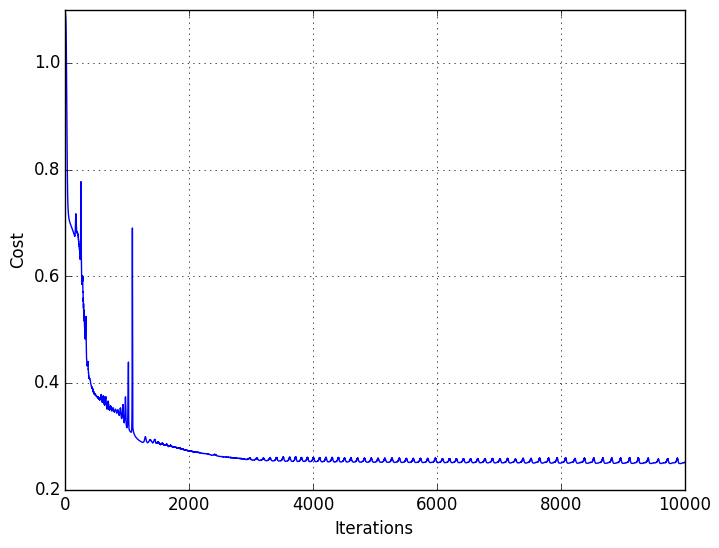

In [19]:
# plot the cost per iteration
plot(1:length(J), J)
xlabel("Iterations")
ylabel("Cost")
grid("on")

This loss function looks reasonable (it might indicate a slightly too small learning rate based on its speed of decay, but it's hard to say), and also indicates that the batch size might be a little too low (since the cost is a little too noisy).

In [20]:
# evaluate training set accuracy
hidden_layer = max(0, X*W1 .+ b1)
scores = hidden_layer*W2 .+ b2
predicted_class = zeros(size(scores,1))
for i in 1:size(scores,1)
    predicted_class[i] = indmax(scores[i,:])
end
#println(predicted_class)
correct = 0;
for i in 1:length(y)
    if y[i] == predicted_class[i]
        correct = correct + 1;
    end
end
println("training accuracy: ", correct/length(y))

training accuracy: 0.9833333333333333


In [21]:

# plot the resulting classifier
h = 0.02;
x_min = minimum(X[:, 1]) - 1;
x_max = maximum(X[:, 1]) + 1;
y_min = minimum(X[:, 2]) - 1;
y_max = maximum(X[:, 2]) + 1;
numX = convert(Int, floor((x_max - x_min)/h));
xx = zeros(numX);
xx[1] = x_min;
yy = zeros(numX);
yy[1] = y_min;
for i in 2:numX
    xx[i] = xx[i-1] + h;
    yy[i] = yy[i-1] + h;
end
grid_x = [i for i in xx, j in yy];
grid_y = [j for i in xx, j in yy];
xy = [grid_x[:] grid_y[:]];
z0 = xy*W1 .+ b1
z0[z0 .< 0] = 0 
z = z0*W2 .+ b2
zz = zeros(size(z,1));
for i in 1:size(z,1)
    zz[i] = indmax(z[i,:])
end
zz = reshape(zz, size(grid_x));

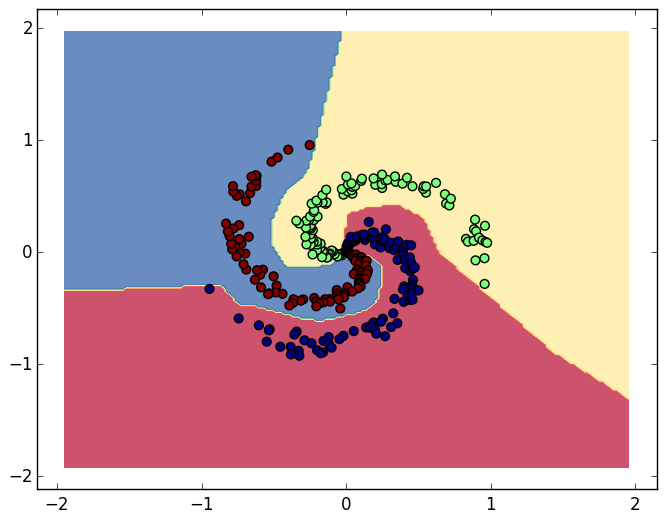

PyObject <matplotlib.collections.PathCollection object at 0x000000002B87A518>

In [22]:
contourf(grid_x, grid_y, zz, cmap=get_cmap("Spectral"), alpha=0.8) 
scatter(X[:, 1], X[:, 2], c=y, s=40)